In [1]:
import pandas as pd
import numpy as np
import catboost as cat
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import telepyth
import talib
from scipy.stats import pearsonr
#from PNL_metric import PNLMetric
data_name = 'Si_1'


df = pd.read_csv('data/{}.csv'.format(data_name))
y = df.y
X_old = df.drop(['y', 'date'], axis=1)
X_full = X_old
print(X_full.shape)

(16618, 215)


In [2]:
def primfacs(n):
    i = 2
    primfac = []
    while i * i <= n:
        while n % i == 0:
            primfac.append(i)
            n = n / i
        i = i + 1
    if n > 1:
        primfac.append(n)
    return primfac
int(primfacs(X_full.shape[0])[-1])

1187

In [3]:
from sklearn.preprocessing import StandardScaler

# X_full = pd.concat([X_old, filtered], axis = 1)
X_full = X_full.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.075, shuffle = False)
print(X_full.shape)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(16618, 215)


In [4]:
from sklearn.linear_model import LogisticRegression
for c in [0.0005, 0.001, 0.002, 0.005, 0.01]:
    lr = LogisticRegression(C = c, random_state = 57, tol = 1e-4, max_iter = 1000)
    lr.fit(X_train, y_train)
    print(lr.score(X_test, y_test), "\n")

0.545308740978348 

0.5501202886928629 

0.5517241379310345 

0.545308740978348 

0.5469125902165196 




Epoch 00001: val_loss improved from inf to 1.55971, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss improved from 1.55971 to 1.51254, saving model to /tmp/weights.hdf5

Epoch 00003: val_loss improved from 1.51254 to 1.46317, saving model to /tmp/weights.hdf5

Epoch 00004: val_loss improved from 1.46317 to 1.41790, saving model to /tmp/weights.hdf5

Epoch 00005: val_loss improved from 1.41790 to 1.37553, saving model to /tmp/weights.hdf5

Epoch 00006: val_loss improved from 1.37553 to 1.33421, saving model to /tmp/weights.hdf5

Epoch 00007: val_loss improved from 1.33421 to 1.29588, saving model to /tmp/weights.hdf5

Epoch 00008: val_loss improved from 1.29588 to 1.25902, saving model to /tmp/weights.hdf5

Epoch 00009: val_loss improved from 1.25902 to 1.22379, saving model to /tmp/weights.hdf5

Epoch 00010: val_loss improved from 1.22379 to 1.19109, saving model to /tmp/weights.hdf5

Epoch 00011: val_loss improved from 1.19109 to 1.16052, saving model to /tmp/weights.hdf5

Ep


Epoch 00092: val_loss improved from 0.69913 to 0.69839, saving model to /tmp/weights.hdf5

Epoch 00093: val_loss improved from 0.69839 to 0.69797, saving model to /tmp/weights.hdf5

Epoch 00094: val_loss did not improve

Epoch 00095: val_loss improved from 0.69797 to 0.69776, saving model to /tmp/weights.hdf5

Epoch 00096: val_loss improved from 0.69776 to 0.69702, saving model to /tmp/weights.hdf5

Epoch 00097: val_loss did not improve

Epoch 00098: val_loss improved from 0.69702 to 0.69675, saving model to /tmp/weights.hdf5

Epoch 00099: val_loss improved from 0.69675 to 0.69663, saving model to /tmp/weights.hdf5

Epoch 00100: val_loss improved from 0.69663 to 0.69619, saving model to /tmp/weights.hdf5

Epoch 00101: val_loss did not improve

Epoch 00102: val_loss improved from 0.69619 to 0.69608, saving model to /tmp/weights.hdf5

Epoch 00103: val_loss improved from 0.69608 to 0.69594, saving model to /tmp/weights.hdf5

Epoch 00104: val_loss improved from 0.69594 to 0.69583, saving 

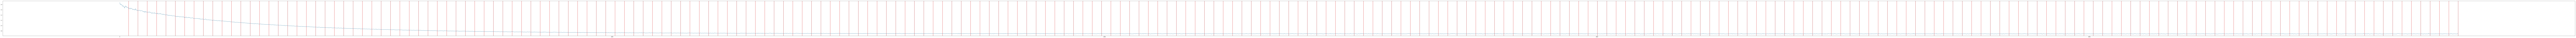

In [65]:
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.optimizers import Adam
import h5py


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

start = 512      
drop_size = 0.4
model = Sequential()
model.add(Dense(start, activation = 'elu', input_dim = 215, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(drop_size))
model.add(Dense(start//2, activation = 'elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(drop_size))
model.add(Dense(start//4, activation = 'elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(drop_size))
model.add(Dense(start//8, activation = 'elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(drop_size))
# model.add(Dense(32, activation = 'elu', kernel_regularizer=regularizers.l2(0.002)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

adam = Adam(decay=0.002)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
history = LossHistory()

num_epochs = 250
size = int(primfacs(X_train.shape[0])[-1])
h = model.fit(X_train, y_train, batch_size=size, epochs=num_epochs, verbose=0, validation_data=(X_test, y_test), 
          callbacks=[history, checkpointer])
plt.rcParams['figure.figsize'] = (num_epochs*2, int(np.sqrt(num_epochs/4)))
xcoords = [X_train.shape[0]*(i+1)/size-1 for i in range(num_epochs)]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
plt.plot(history.losses)

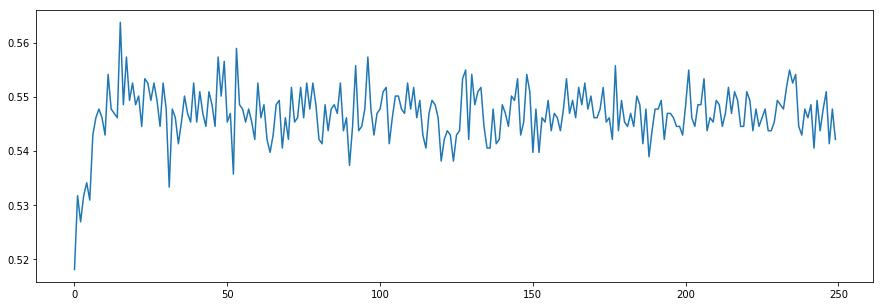

In [66]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(h.history['val_acc'])

<h1>LSTM</h1>

In [150]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.optimizers import Adam

print(y.shape[0])
max_div = int(primfacs(y.shape[0])[-1])
print(max_div)
length = 2
print(y.shape[0] - length + 1)
max_div = int(primfacs(y.shape[0] - length + 1)[-1])
print(max_div)
#the length of the data_gen will be (y.shape[0]-length+1)/batch_size
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
data_gen = TimeseriesGenerator(X_scaled, y, length = length, sampling_rate = 1, stride = 1,
                               batch_size = 191, shuffle = False)
print(len(data_gen))
data_gen

16618
1187
16617
191
87


In [152]:
start = 64      
drop_size = 0.4
model = Sequential()
model.add(SimpleRNN(units = start, activation = 'relu', stateful = True, return_sequences = False,
                   batch_input_shape = (191, 2, 215)))
model.add(Dense(1, activation = 'sigmoid'))

adam = Adam(decay=0.002)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
history = LossHistory()

num_epochs = 250
h = model.fit_generator(data_gen, validation_data = 0.075, shuffle = False, epochs = num_epochs)
#           callbacks=[history, checkpointer])
plt.rcParams['figure.figsize'] = (num_epochs*2, int(np.sqrt(num_epochs/4)))
xcoords = [X_train.shape[0]*(i+1)/size-1 for i in range(num_epochs)]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
plt.plot(history.losses)

TypeError: object of type 'float' has no len()